In [2]:
from datasets import load_dataset, Dataset
from langchain.embeddings import HuggingFaceBgeEmbeddings
from qdrant_client import models, QdrantClient
from langchain.vectorstores import Qdrant
import time
from datetime import timedelta
import pandas as pd
from pandas import DataFrame
from matplotlib import pyplot as plt
import numpy as np


TODO
- [x] Turn off streaming
- [x] Add counter
- [x] Implement saving
- [x] Put into script
- [x] Double check if dataset loaders are working
- [x] Check for smaller datasets and a safe way for next (next(data, sentinel)?)
- [] Check for optimization (batch processing of data, especially embedding)

## Overview of the dataset attributes
- split: To which part of the dataset it belongs (retrieval or llm training)
- query: The actual question or query
- prediction: The outcome it should provide
– context: The retrieved/provided context which is used as background
- src: The source of the question/the name of the dataset 
- id: The id of the sample, which does not have a true format
- context_src: The source of the context (src dataset/wiki/cc)
- context_id: The id of the context
- original_context: If the context is provided or retrieved
- task: The kind of task summ/qa/multiple choice
- domain: The domain of the question open-domain qa/rc/summ/cotr ...

In [7]:
col_name = "retriever"

#tokenizer = LlamaTokenizer.from_pretrained("../models/llama7b", device_map='cuda')
embedding = HuggingFaceBgeEmbeddings(model_name="../models/retriever/bge-base-en-v1.5", model_kwargs={"device": "cuda:0"})

# Create the retriever
client = QdrantClient(url="http://localhost:6333")
db = Qdrant(client, 
            collection_name=col_name,
            embeddings=embedding,
            )

def search(query: str, k: int = 3):
    success = False
    while not success:
        try:
            results = db.similarity_search_with_score(query, k=k)
            if results:
                success = True 
        except:
            print(f"Error with example {query}, retrying in 0.2s")
            time.sleep(0.2)
    return results

# This function creates an example with the query and the prediction and the top k results
def make_example(query: str, prediction:str, dataset_name:str, context = None, example_id = None, k: int = 3, split = "llm", retrieval = True, task="", domain=""):
    contexts = []
    if retrieval:
        # Search for the query
        results = search(query, k=k)

        # Get the text of the results
        contexts = [{
            "text": result[0].page_content, 
            "src": result[0].metadata["src"] if "src" in result[0].metadata.keys() else "unknown", 
            "id": result[0].metadata["id"] if "id" in result[0].metadata.keys() else result[0].metadata["title"],
            "original_context": False } 
            for result in results]
    
    # Add the original context
    if context:
        contexts.append({
            "text": context, 
            "src": dataset_name, 
            "id": str(example_id), 
            "original_context": True
            })

    return { 
        "split": split, 
        "query": query, 
        "prediction": prediction, 
        "contexts": contexts, 
        "src": dataset_name, 
        "id": str(example_id),
        "task": task,
        "domain": domain, 
        }

# Depending if the examples should be searved consecutively or not (shuffling not possible with all contexts in one example)
# This function creates a list of examples with one for each context
def make_examples(query: str, prediction:str, dataset_name:str, context = None, example_id = None, k: int = 3, retrieval = True, task="", domain=""):
    examples = []
    ex = make_example(query, prediction, dataset_name, context, example_id, k, retrieval=retrieval, task=task, domain=domain)
    for c in ex["contexts"]:
        examples.append({ 
            "split": ex["split"], 
            "query": ex["query"], 
            "prediction": ex["prediction"], 
            "context": c["text"], 
            "src": ex["src"], 
            "id": str(ex["id"]), 
            "context_src": c["src"], 
            "context_id": str(c["id"]), 
            "original_context": c["original_context"],
            "task": task,
            "domain": domain,
            })
    return examples

itrf_dataset_buffer = []
itrf = DataFrame(columns=["split", "query", "prediction", "context", "src", "id", "context_src", "context_id", "original_context", "task", "domain"])

def save_example(i, start, last_time, example, dname, force=False):
    save_examples(i, start, last_time, [example], dname, force=force)

def save_examples(i, start, last_time, examples, dname, force=False):
    global itrf_dataset_buffer
    global itrf
    # Save the dataset to a file
    itrf_dataset_buffer.extend(examples)
    
    if i % 100 == 0 or force:
        current_time = time.time()
        print(f"Processed {i} {dname} examples, time: {str(timedelta(seconds=(last_time - start)))}, last 100 in {str(timedelta(seconds=(current_time - last_time)))}")
        last_time = current_time
        if len(itrf_dataset_buffer) > 0:
            if itrf.empty:
                itrf = DataFrame(itrf_dataset_buffer)
            else:
                df = DataFrame(itrf_dataset_buffer)
                itrf = pd.concat([itrf, df])
            itrf_dataset_buffer.clear()
        itrf.to_parquet("../data/dataset/itrf_dataset_llm.parquet")
        itrf.to_csv("../data/dataset/itrf_dataset_llm.csv")

### Maintainance and testing

In [44]:
col = client.get_collection(collection_name=col_name)
status = col.status
optimizer = col.optimizer_status
ivecs = col.indexed_vectors_count
vecs = col.points_count

print(f"Collection status: {status}") # If collection status green, then it is ready to be used
print(f"Optimizer status: {optimizer}")
print(f"Total vectors: {vecs}")
print(f"Indexed vectors: {ivecs}")

Collection status: green
Optimizer status: ok
Total vectors: 184329218
Indexed vectors: 184329218


In [13]:
# Set to 0 to disable indexing during upload
# Set to 20000 to enable indexing after upload - check the status with the cell above
client.update_collection(
    collection_name=col_name,
    optimizer_config=models.OptimizersConfigDiff(indexing_threshold=20000),
)

True

In [30]:
# The corpus is of questionble quality
# Try to filter out some of the bad documents by reranker
start = time.time()
search_res = db.similarity_search_with_score("When did Albert Einstein die?", k=10) # Alternatively "mml" for maximal marginal relevance
elapsed = (time.time() - start)
clock = str(timedelta(seconds=elapsed))

for i, (doc, score) in enumerate(search_res):
    print(f"{i+1}. {score:.2f} {doc.page_content[:100]}")
print(f"Time: {clock}")

1. 0.82 Albert Einstein (March 14, 1879-April 18, 1955) Albert Einstein was born March 14, 1879 in Ulm, Wurt, time: 0:00:00.050777
2. 0.81 Hans Albert Einstein died due to heart failure on July 26, 1973 (aged 69) in Woods Hole, Massachuset, time: 0:00:00.050777
3. 0.81 Just as the name Frankenstein elicits visions of monsters, the name Einstein is synonymous with geni, time: 0:00:00.050777
4. 0.80 Albert Einstein’s name is almost synonymous. leading him to fight racism in the U.S. Einstein died A, time: 0:00:00.050777
5. 0.79 unified fieldtheory, which however was not successful. Albert Einstein died onApril 18, 1955. He was, time: 0:00:00.050777
6. 0.79 Today we remember renowned physicist Albert Einstein, who died April 18, 1955 at the age of 76. Born, time: 0:00:00.050777
7. 0.78 note that my friend and colleague M. Besso steadfastly stood by me in my work on the problem here di, time: 0:00:00.050777
8. 0.78 Einstein died of heart trouble, in Manhattan, New York County, New York, on

In [13]:
# This should be the estimated upper bound for the dataset size
# With 10 samples in memory, 750 times more, about 20 datasets in total
# Times two to accommondate for outliers
DataFrame(itrf_dataset_buffer).memory_usage(deep=True).sum() * 750 * 20 * 2

# Resulting in about 1.3 GB of data


1291890000

# Building the Dataset for the LLM
In this Notebook we're gonna build up the dataset for training of the LLM consisting of many different smaller datasets where we sample subsets

In [8]:
n = 10
itrf_dataset_buffer = []
k=3
options_enabled = True

## Open domain questioning

In [9]:
datasets_openqa = ["tau/commonsense_qa", "math_qa", "web_questions", "wiki_qa", "yahoo_answers_qa", "freebase_qa", "ms_marco"]

In [10]:
dataset = load_dataset(datasets_openqa[4], split="train", streaming=True)
shuffled = iter(dataset.shuffle(buffer_size=10_000, seed=2024))
next(shuffled)


{'id': '2336421',
 'question': 'how can i mak my website visitors to come back soon and may not leave the website ?i want 10 charactris?',
 'answer': "It appears that the question period has expired. If you have received an answer that meets your needs, please choose a 'best answer.'. Regards.",
 'nbestanswers': ["It appears that the question period has expired. If you have received an answer that meets your needs, please choose a 'best answer.'. Regards.",
  "1. Good information. . 97% use the Internet to become better informed and, according to Forrester Research, high quality content is the most popular reason for returning to a site. Including informative pages on a website adds value, making it more than simply an online brochure or shop window. If you are retailing products, include information on after care or answer frequently asked questions (FAQs) on a dedicated page. A site that provides useful information sticks in a user's mind and will be. revisited in the future.. . 2. U

### Ready datasets

#### tau/commonsense_qa

In [11]:
# def make_examples(query: str, prediction:str, dataset_name:str, context = None, example_id = None, k: int = 3, retrieval = True)
dname = datasets_openqa[0]
dataset = load_dataset(dname, split="train")
shuffled = iter(dataset.shuffle(seed=2024))
start = time.time()
last_time = start
for i in range(n):
    example = next(shuffled)

    options = ""
    if options_enabled:
        options = "\n Options: "
    answer = -1
    for idx, o in enumerate(example["choices"]["label"]):
        if options_enabled:
            options += f"{o}: {example['choices']['text'][idx]}, "
        if example["answerKey"] == o:
            answer = idx
    if options_enabled: 
        options += "\n"

    query = example["question"] + options
    if options_enabled:
        prediction = f"{example['answerKey']}) {example['choices']['text'][answer]}"
    else:
        prediction =  f"{example['choices']['text'][answer]}"
    example_id = example["id"] + "_" + example["question_concept"]
    examples = make_examples(query, prediction, dname, example_id=example_id, k=k, retrieval=True, task="mc", domain="openqa")
    
    save_examples(i, start, last_time, examples, dname)

itrf_dataset_buffer

Processed 0 tau/commonsense_qa examples, time: 0:00:00, last 100 in 0:00:00.112640


[{'split': 'llm',
  'query': "The ficus tree isn't native to the state of actors and surfers but you can find them where?\n Options: A: front yard, B: california, C: farm, D: conservatory, E: tropical forest, \n",
  'prediction': 'B) california',
  'context': 'Ficus ficus is found in the Indian Ocean and the West Pacific.',
  'src': 'tau/commonsense_qa',
  'id': '41dfc69ea81b7e7ab1cceb690a12b6b0_ficus',
  'context_src': 'wiki',
  'context_id': 'Ficus ficus',
  'original_context': False,
  'task': 'mc',
  'domain': 'openqa'},
 {'split': 'llm',
  'query': "The ficus tree isn't native to the state of actors and surfers but you can find them where?\n Options: A: front yard, B: california, C: farm, D: conservatory, E: tropical forest, \n",
  'prediction': 'B) california',
  'context': 'Fact #1127: The tallest tree, the largest tree (by volume) and the oldest tree (non-clonal) in the world are all located in California.',
  'src': 'tau/commonsense_qa',
  'id': '41dfc69ea81b7e7ab1cceb690a12b6

#### math_qa

In [12]:
# def make_examples(query: str, prediction:str, dataset_name:str, context = None, example_id = None, k: int = 3, retrieval = True)
dname = datasets_openqa[1]
dataset = load_dataset(dname, split="train")
shuffled = iter(dataset.shuffle(seed=2024))
start = time.time()
last_time = start
for i in range(n):
    example = next(shuffled)
    options = ""
    if options_enabled:
        options =  "\nOptions: " + example["options"]
    query = example["Problem"] + options

    answer = ""
    if options_enabled:
        answer = example["correct"] + ") "

    # Extract actual answer from options
    for idx, o in enumerate(example["options"].split(",")):
        a = o.split(" ) ")
        if example["correct"] == a[0].strip():
            answer += a[1]

    prediction = answer
    example_id = example["category"] + "_" + str(i)
    examples = make_examples(query, prediction, dname, example_id=example_id, k=k, retrieval=True, task="mc", domain="openqa")
    
    save_examples(i, start, last_time, examples, dname)
itrf_dataset_buffer

Processed 0 math_qa examples, time: 0:00:00, last 100 in 0:00:00.026468


[{'split': 'llm',
  'query': 'a grocer is storing soap boxes in cartons that measure 25 inches by 42 inches by 60 inches . if the measurement of each soap box is 7 inches by 12 inches by 5 inches , then what is the maximum number of soap boxes that can be placed in each carton ?\nOptions: a ) 210 , b ) 150 , c ) 280 , d ) 300 , e ) 420',
  'prediction': 'b) 150 ',
  'context': 'I was wondering if you could make a box that holds soap that measures 4×3.5 I have no idea of how to construct one of these, please please please help me…LOL!\nI just love the above box but I wondered if it will hold 6, 2×2″ brownies? If not then can you plz give me a measurement for a box of that size. Please need ur help on this',
  'src': 'math_qa',
  'id': 'general_1',
  'context_src': 'oscar',
  'context_id': '5814499',
  'original_context': False,
  'task': 'mc',
  'domain': 'openqa'},
 {'split': 'llm',
  'query': 'a grocer is storing soap boxes in cartons that measure 25 inches by 42 inches by 60 inches .

In [13]:
itrf

,split,query,prediction,context,src,id,context_src,context_id,original_context,task,domain
0,llm,If a person needs food from a dairy what shoul...,D) milk cow,2.1 Determine the range of possible sources. W...,tau/commonsense_qa,8a17c3c690e3f0f37a5f8b5858e0ad6a_person,oscar,5763584,False,mc,openqa
1,llm,If a person needs food from a dairy what shoul...,D) milk cow,battered with dairy. If you eat something that...,tau/commonsense_qa,8a17c3c690e3f0f37a5f8b5858e0ad6a_person,oscar,11558750,False,mc,openqa
2,llm,If a person needs food from a dairy what shoul...,D) milk cow,"What if I went to a dairy, and they said, ""You...",tau/commonsense_qa,8a17c3c690e3f0f37a5f8b5858e0ad6a_person,oscar,5645054,False,mc,openqa
0,llm,The ficus tree isn't native to the state of ac...,B) california,Ficus ficus is found in the Indian Ocean and t...,tau/commonsense_qa,41dfc69ea81b7e7ab1cceb690a12b6b0_ficus,wiki,Ficus ficus,False,mc,openqa
1,llm,The ficus tree isn't native to the state of ac...,B) california,"Fact #1127: The tallest tree, the largest tree...",tau/commonsense_qa,41dfc69ea81b7e7ab1cceb690a12b6b0_ficus,oscar,7564568,False,mc,openqa
2,llm,The ficus tree isn't native to the state of ac...,B) california,This is my friend’s hand. I call her Miss Flor...,tau/commonsense_qa,41dfc69ea81b7e7ab1cceb690a12b6b0_ficus,oscar,9919082,False,mc,openqa
3,llm,Where would someone find freshest possible egg...,E) chicken coop,3. The eggs are tastier. Grocery store eggs ca...,tau/commonsense_qa,710b3dac066dd46f56190ad1296f064c_egg,oscar,3578192,False,mc,openqa
4,llm,Where would someone find freshest possible egg...,E) chicken coop,"the counter. That's right, leave them on the c...",tau/commonsense_qa,710b3dac066dd46f56190ad1296f064c_egg,oscar,3523282,False,mc,openqa
5,llm,Where would someone find freshest possible egg...,E) chicken coop,fresh. You won’t find all food items easily av...,tau/commonsense_qa,710b3dac066dd46f56190ad1296f064c_egg,oscar,10271343,False,mc,openqa
6,llm,"It was dumb luck, his bad move had actually pu...",B) advantageous,"A: Today it looked like he lowered his head, l...",tau/commonsense_qa,a210201a0cb52498009bea002974f064_1_bad,oscar,8517286,False,mc,openqa


#### web_questions

In [14]:
# def make_examples(query: str, prediction:str, dataset_name:str, context = None, example_id = None, k: int = 3, retrieval = True)
dname = datasets_openqa[2]
dataset = load_dataset(dname, split="train")
shuffled = iter(dataset.shuffle(seed=2024))
start = time.time()
last_time = start
for i in range(n):
    example = next(shuffled)

    query = example["question"]
    prediction =  example["answers"][0]
    example_id = example["url"] + "_" + example["answers"][0]
    examples = make_examples(query, prediction, dname, example_id=example_id, k=k, retrieval=True, task="qa", domain="openqa")
    
    save_examples(i, start, last_time, examples, dname)
itrf_dataset_buffer

Processed 0 web_questions examples, time: 0:00:00, last 100 in 0:00:00.045430


[{'split': 'llm',
  'query': 'where did prophet daniel died?',
  'prediction': 'Babylon',
  'context': "The Martyrologium Romanum of 1584 assigned Saint Daniel's feastday  to July 21. The place of his death is given as Babylon, Mesopotamia. Though this martyrology does not say so, it was claimed that he was buried in the royal vault there.",
  'src': 'web_questions',
  'id': 'http://www.freebase.com/view/en/daniel_Babylon',
  'context_src': 'wiki',
  'context_id': 'Tomb of Daniel',
  'original_context': False,
  'task': 'qa',
  'domain': 'openqa'},
 {'split': 'llm',
  'query': 'where did prophet daniel died?',
  'prediction': 'Babylon',
  'context': 'The Tomb of Daniel (Persian: آرامگاه دانیال نبی) is the traditional burial place of the biblical figure Daniel. Various locations have been named for the site, but the tomb in Susa, Iran (Persia), is the most widely accepted, it being first mentioned by Benjamin of Tudela, who visited Asia between 1160 and 1163.',
  'src': 'web_questions',

#### Wiki QA

In [20]:
{'question_id': 'Q328',
 'question': 'WHAT COUNTRY IS MEXICO IN',
 'document_title': 'Mexico',
 'answer': 'It has the fourteenth largest nominal GDP and the eleventh largest GDP by purchasing power parity .',
 'label': 0}

{'question_id': 'Q328',
 'question': 'WHAT COUNTRY IS MEXICO IN',
 'document_title': 'Mexico',
 'answer': 'It has the fourteenth largest nominal GDP and the eleventh largest GDP by purchasing power parity .',
 'label': 0}

In [15]:
# def make_examples(query: str, prediction:str, dataset_name:str, context = None, example_id = None, k: int = 3, retrieval = True)
dname = datasets_openqa[3]
dataset = load_dataset(dname, split="train")
shuffled = iter(dataset.shuffle(seed=2024))
start = time.time()
last_time = start
for i in range(n):
    example = next(shuffled)

    query = example["question"]
    prediction =  example["answer"]
    example_id = example["question_id"] + "_" + example["document_title"]
    examples = make_examples(query, prediction, dname, example_id=example_id, k=k, retrieval=True, task="qa", domain="openqa")
        
    save_examples(i, start, last_time, examples, dname)
itrf_dataset_buffer

Generating train split: 100%|██████████| 20360/20360 [00:00<00:00, 932454.30 examples/s]


Processed 0 wiki_qa examples, time: 0:00:00, last 100 in 0:00:03.081067


[{'split': 'llm',
  'query': 'who played in the 2010 NBA Finals',
  'prediction': 'This was the first NBA Finals to go the full seven games since and only the fourth since the NBA Finals returned to a 2–3–2 format in .',
  'context': "Nba Finals Game 5 Score Board - Cavaliers warriors - nba., James and cavaliers win thrilling nba finals game 7, 93-89 by janie mccauley posted jun 20 2016 2:06am. oakland, calif. (ap) lebron james cradled the shiny gold trophy and struggled to sum up what. 2010 nba finals - wikipedia, The 2010 nba finals was the national basketball association (nba)'s championship series for the 2009–10 season.the best-of-seven playoff was contested between the western conference champion los angeles lakers (who were also defending nba champions), and the eastern conference champion boston celtics.the lakers defeated the celtics, four games to three, to",
  'src': 'wiki_qa',
  'id': 'Q1700_2010 NBA Finals',
  'context_src': 'oscar',
  'context_id': '6677321',
  'original_

#### yahoo answers qa

In [16]:
# def make_examples(query: str, prediction:str, dataset_name:str, context = None, example_id = None, k: int = 3, retrieval = True)
dname = datasets_openqa[4]
dataset = load_dataset(dname, split="train")
shuffled = iter(dataset.shuffle(seed=2024))
start = time.time()
last_time = start
for i in range(n):
    example = next(shuffled)

    query = example["question"]
    prediction =  example["answer"]
    example_id = example["id"] + "_" + example["main_category"]
    examples = make_examples(query, prediction, dname, example_id=example_id, k=k, retrieval=True, task="qa", domain="openqa")
        
    save_examples(i, start, last_time, examples, dname)
itrf_dataset_buffer

Generating train split: 100%|██████████| 87362/87362 [00:04<00:00, 21537.89 examples/s]


Processed 0 yahoo_answers_qa examples, time: 0:00:00, last 100 in 0:00:02.188376


[{'split': 'llm',
  'query': 'how to market printing paper?',
  'prediction': 'give your target market different reasons to print and to use your paper.... . try also to emphasize the good characteristics of your printing paper as compared to others.... . good luck!',
  'context': 'Print Marketing is a great way to stand out and get your message exactly into the hands of your potential customers. But where do you start?',
  'src': 'yahoo_answers_qa',
  'id': '3782974_Business & Finance',
  'context_src': 'oscar',
  'context_id': '3396438',
  'original_context': False,
  'task': 'qa',
  'domain': 'openqa'},
 {'split': 'llm',
  'query': 'how to market printing paper?',
  'prediction': 'give your target market different reasons to print and to use your paper.... . try also to emphasize the good characteristics of your printing paper as compared to others.... . good luck!',
  'context': 'Printing a paper in a niche market is the means to go! Picture having your own paper to hand out, to de

## Reading comprehension

In [17]:
datasets_reading = ["coqa", "drop", "narrativeqa", "newsqa", ("pubmed_qa", "pqa_unlabeled"), "quail", "quarel", "squad_v2"] # "natural_questions", "trivia_qa",  "search_qa", "", "duorc", "ropes"

#### CoQA

In [18]:
# def make_examples(query: str, prediction:str, dataset_name:str, context = None, example_id = None, k: int = 3, retrieval = True)
dname = datasets_reading[0]
dataset = load_dataset(dname, split="train")
shuffled = iter(dataset.shuffle(seed=2024))
start = time.time()
last_time = start
for i in range(n):
    example = next(shuffled)

    query = example["questions"][0]
    prediction =  example["answers"]['input_text'][0]
    example_id = example["source"] + "_" + str(i)
    context = example["story"]
    examples = make_examples(query, prediction, dname, example_id=example_id, context=context, k=k, retrieval=True, task="qa", domain="rc")
        
    save_examples(i, start, last_time, examples, dname)
itrf_dataset_buffer

Processed 0 coqa examples, time: 0:00:00, last 100 in 0:00:00.048334


[{'split': 'llm',
  'query': 'Which rank is this article about?',
  'prediction': 'Kingdom',
  'context': 'Ranks include:',
  'src': 'coqa',
  'id': 'wikipedia_1',
  'context_src': 'wiki',
  'context_id': 'Waterfront Commission of New York Harbor',
  'original_context': False,
  'task': 'qa',
  'domain': 'rc'},
 {'split': 'llm',
  'query': 'Which rank is this article about?',
  'prediction': 'Kingdom',
  'context': 'rank to be mentioned.',
  'src': 'coqa',
  'id': 'wikipedia_1',
  'context_src': 'oscar',
  'context_id': '5979117',
  'original_context': False,
  'task': 'qa',
  'domain': 'rc'},
 {'split': 'llm',
  'query': 'Which rank is this article about?',
  'prediction': 'Kingdom',
  'context': 'Army general is a title used in many countries to denote the rank of general nominally commanding an army in the field. Army general is normally the highest rank used in peacetime. The equivalent position in the Commonwealth, U.S., and several other countries is simply termed general, four-s

#### drop

In [19]:
# def make_examples(query: str, prediction:str, dataset_name:str, context = None, example_id = None, k: int = 3, retrieval = True)
# This dataset seems to have a lot of duplicates so we remove them
dname = datasets_reading[1]
dataset = load_dataset(dname, split="train").to_pandas()
dataset.drop_duplicates(subset=["section_id"], keep="first", inplace=True)
dataset = Dataset.from_pandas(dataset)
shuffled = iter(dataset.shuffle(seed=2024))
start = time.time()
last_time = start
for i in range(n):
    example = next(shuffled)

    query = example["question"]
    spans = example["answers_spans"]['spans']
    if len(spans) > 1:
        prediction =  ", ".join(spans)
    else:
        prediction = spans[0]
    
    example_id = example["query_id"]
    context = example["passage"]
    examples = make_examples(query, prediction, dname, example_id=example_id, context=context, k=k, retrieval=True, task="qa", domain="rc")
        
    save_examples(i, start, last_time, examples, dname)
itrf_dataset_buffer

Processed 0 drop examples, time: 0:00:00, last 100 in 0:00:00.289811


[{'split': 'llm',
  'query': 'How many yards was the longest field goal in the game?',
  'prediction': '53',
  'context': "The longest successful field goal in NFL history was 66 yards by Justin Tucker of the Baltimore Ravens against the Detroit Lions on September 26, 2021. The longest field goal attempt in an NFL game was 76 yards by Sebastian Janikowski of the Oakland Raiders against the San Diego Chargers on September 28, 2008. Prior to Dempsey's 1970 kick, the longest field goal in NFL history was 56 yards, by Bert Rechichar of the Baltimore Colts in 1953. A 55-yard field goal, achieved by a drop kick, was recorded by Paddy Driscoll in, and stood as the unofficial record until that point; some sources indicate a 54-yarder by Glenn Presnell in as the record, due to the inability to precisely verify Driscoll's kick. In a pre-season NFL game between the Denver Broncos and the Seattle Seahawks on August 29, 2002, Ola Kimrin kicked a 65-yard field goal. However, because pre-season games

#### narrativeqa

In [20]:
# def make_examples(query: str, prediction:str, dataset_name:str, context = None, example_id = None, k: int = 3, retrieval = True)
# This dataset seems to have a lot of duplicates so we remove them
dname = datasets_reading[2]
dataset = load_dataset(dname, split="train")
shuffled = iter(dataset.shuffle(seed=2024))
start = time.time()
last_time = start
for i in range(n):
    example = next(shuffled)

    query = example["question"]["text"]
    prediction =  example["answers"][0]['text']
    example_id = example["document"]["id"] + "_" + str(i)
    context = example["document"]["summary"]["text"]
    examples = make_examples(query, prediction, dname, example_id=example_id, context=context, k=k, retrieval=True, task="qa", domain="rc")
        
    save_examples(i, start, last_time, examples, dname)
itrf_dataset_buffer

Processed 0 narrativeqa examples, time: 0:00:00, last 100 in 0:00:00.131497


[{'split': 'llm',
  'query': 'How old is Benny when the story begins?',
  'prediction': 'Benny is ten years old.',
  'context': 'According to the Doctor, Benny was born on an Earth colony in 2422 [dating Love and War to 2452]. She has been travelling with the Doctor for "a couple of years" [which means that she is now thirty-two years old]. Bernice does "an uncanny" impression of the Doctor\'s voice. She loses two pints of blood when attacked by the vampire plants. Believing that Gabriel and Tanith will kill her, she tells Ace that she loves her and the Doctor. She does indeed die here, temporarily killed as part of Gabriel and Tanith\'s games, and resurrected in/by Cathedral. She is terrified',
  'src': 'narrativeqa',
  'id': '902585a8b22580b312f1ac76591192adf4e79e03_1',
  'context_src': 'oscar',
  'context_id': '11360986',
  'original_context': False,
  'task': 'qa',
  'domain': 'rc'},
 {'split': 'llm',
  'query': 'How old is Benny when the story begins?',
  'prediction': 'Benny is t

#### newsqa - not working

In [21]:
# Unfinished

dname = datasets_reading[3]
dataset = load_dataset(dname, split="train")
shuffled = iter(dataset.shuffle(seed=2024))
start = time.time()
last_time = start
for i in range(n):
    example = next(shuffled)

    query = example["question"]["text"]
    prediction =  example["answers"][0]['text']
    example_id = example["document"]["id"] + "_" + str(i)
    context = example["document"]["summary"]["text"]
    examples = make_examples(query, prediction, dname, example_id=example_id, context=context, k=k, retrieval=True, task="qa", domain="rc")
        
    save_examples(i, start, last_time, examples, dname)
itrf_dataset_buffer

ManualDownloadError:                     The dataset newsqa with config split requires manual data.
                    Please follow the manual download instructions:
                     Due to legal restrictions with the CNN data and data extraction. The data has to be downloaded from several sources and compiled as per the instructions by Authors.
Upon obtaining the resulting data folders, it can be loaded easily using the datasets API.
Please refer to (https://github.com/Maluuba/newsqa) to download data from Microsoft Reseach site (https://msropendata.com/datasets/939b1042-6402-4697-9c15-7a28de7e1321) and a CNN datasource (https://cs.nyu.edu/~kcho/DMQA/) and run the scripts present here (https://github.com/Maluuba/newsqa).
This will generate a folder named "split-data" and a file named "combined-newsqa-data-v1.csv".
Copy the above folder and the file to a directory where you want to store them locally.
                    Manual data can be loaded with:
                     datasets.load_dataset("newsqa", data_dir="<path/to/manual/data>")

#### Pubmed qa

In [22]:
dname = datasets_reading[4][0]
dataset = load_dataset(dname,  datasets_reading[4][1], split="train")
shuffled = iter(dataset.shuffle(seed=2024))
start = time.time()
last_time = start
for i in range(n):
    example = next(shuffled)

    query = example["question"]
    prediction =  example["long_answer"]
    example_id = example["pubid"]
    context = " ".join(example["context"]["contexts"])
    examples = make_examples(query, prediction, dname, example_id=example_id, context=context, k=k, retrieval=True, task="qa", domain="rc")
        
    save_examples(i, start, last_time, examples, dname)
itrf_dataset_buffer

Generating train split: 100%|██████████| 61249/61249 [00:00<00:00, 196430.96 examples/s]


Processed 0 pubmed_qa examples, time: 0:00:00, last 100 in 0:00:02.192068


[{'split': 'llm',
  'query': 'Is diffusion-weighted magnetic resonance imaging superior to positron emission tomography with fludeoxyglucose F 18 in imaging non-small cell lung cancer?',
  'prediction': 'Diffusion-weighted magnetic resonance imaging is equivalent to positron emission tomography in distinguishing non-small cell lung cancer from benign pulmonary nodules but is not as useful for predicting aggressiveness of non-small cell lung cancer.',
  'context': 'Emerging evidence suggests that diffusion-weighted magnetic resonance imaging (DW MRI) could be useful for tumor detection with N and M staging of lung cancer in place of fluorine 18 fluorodeoxyglucose positron emission tomography/computed tomography (FDG PET/CT). DW MRI at 3.0 T and FDG PET/CT were performed before therapy in 113 patients with pulmonary nodules. Mean apparent diffusion coefficient (ADC), maximal standardized uptake value (SUVmax ) and Ki-67 scores were assessed. Quantitatively, specificity and accuracy of AD

#### quail

In [23]:
dname = datasets_reading[5]
dataset = load_dataset(dname, split="train")
shuffled = iter(dataset.shuffle(seed=2024))
start = time.time()
last_time = start
for i in range(n):
    example = next(shuffled)

    query = example["question"]
    prediction =  example["answers"][example["correct_answer_id"]]
    if example["question_type"] == "Unanswerable":
        prediction = "I don't know."
    example_id = example["id"]
    context = " ".join(example["context"])
    examples = make_examples(query, prediction, dname, example_id=example_id, context=context, k=k, retrieval=True, task="qa", domain="rc")
        
    save_examples(i, start, last_time, examples, dname)
itrf_dataset_buffer

Processed 0 quail examples, time: 0:00:00, last 100 in 0:00:00.032352


[{'split': 'llm',
  'query': 'How long was the Getty Teen Lab internship over the summer for?',
  'prediction': 'four weeks',
  'context': 'The intern will help to curate a show and learn preparator skills to assist in hanging that same show. There will also be gallery programming that will go along with the show that the intern will manage.\nThis is a full-time (40 hour per week) paid, 10-week internship that is funded by the Getty Museum Trust.',
  'src': 'quail',
  'id': 'b006_9',
  'context_src': 'oscar',
  'context_id': '13154766',
  'original_context': False,
  'task': 'qa',
  'domain': 'rc'},
 {'split': 'llm',
  'query': 'How long was the Getty Teen Lab internship over the summer for?',
  'prediction': 'four weeks',
  'context': 'In order to increase diversity in the professions related to museums and the visual arts, the Getty is offering a summer internship in the Art Center College of Design Archives to undergraduate students of culturally diverse backgrounds.\nPart of the Co

#### quarel

In [24]:
dname = datasets_reading[6]
dataset = load_dataset(dname, split="train")
shuffled = iter(dataset.shuffle(seed=2024))
start = time.time()
last_time = start
for i in range(n):
    example = next(shuffled)

    query = example["question"].split("(A)")[0]
    if options_enabled:
        query += "\n Options: (A)" + example["question"].split("(A)")[1]

    answers = example["question"].split("(A)")[1].split("(B)")
    prediction =  answers[example["answer_index"]].strip()
    example_id = example["id"]
    examples = make_examples(query, prediction, dname, example_id=example_id, k=k, retrieval=True, task="mc", domain="rc")
        
    save_examples(i, start, last_time, examples, dname)
itrf_dataset_buffer

Processed 0 quarel examples, time: 0:00:00, last 100 in 0:00:00.037137


[{'split': 'llm',
  'query': 'Two paper planes are thrown at a time, into the air. One is made of thick cardboard, one is made of thin paper. Which paper plane flies faster? \n Options: (A) cardboard plane (B) paper plane',
  'prediction': 'paper plane',
  'context': "though you can't see it. A flat sheet of document falling downwards pushes against the air in its path. The air pushes back against the paper and slows its fall. A crumpled piece of paper has a smaller surface pushing against the air. The air doesn't push back as strongly as with the smooth piece, and the ball of paper falls faster. The spread-out wings of a paper aeroplane keep it from falling quickly down to the ground. We say the wings give a plane lift.",
  'src': 'quarel',
  'id': 'QuaRel_V1_B5_1105',
  'context_src': 'oscar',
  'context_id': '4608983',
  'original_context': False,
  'task': 'mc',
  'domain': 'rc'},
 {'split': 'llm',
  'query': 'Two paper planes are thrown at a time, into the air. One is made of thic

#### squad v2

In [25]:
# Counting the unswerable questions in the dataset
dname = datasets_reading[7]
print(dname)
dataset = load_dataset(dname, split="train")
shuffled = iter(dataset.shuffle(seed=2024))

unanswerable = 0
for i in range(15000):
    example = next(shuffled)
    if len(example["answers"]["text"]) == 0:
        unanswerable += 1
print(unanswerable)
        

squad_v2
4955


In [26]:
dname = datasets_reading[7]
dataset = load_dataset(dname, split="train")
shuffled = iter(dataset.shuffle(seed=2024))
start = time.time()
last_time = start
for i in range(n*2):
    example = next(shuffled)

    query = example["question"]
    answer = example["answers"]["text"]
    prediction = ""
    if len(answer) == 0:
        prediction = "I don't know."
    else:
        prediction = answer[0]
    example_id = example["id"]
    context = " ".join(example["context"])
    examples = make_examples(query, prediction, dname, example_id=example_id, context=context, k=k, retrieval=True, task="qa", domain="rc")
        
    save_examples(i, start, last_time, examples, dname)
itrf_dataset_buffer

Processed 0 squad_v2 examples, time: 0:00:00, last 100 in 0:00:00.026593


[{'split': 'llm',
  'query': 'In what year was the St. Louis Medical College founded?',
  'prediction': "I don't know.",
  'context': "Saint Louis University School of Medicine (SLUSOM) is a private, American Medical School within Saint Louis University. Located in the city of St. Louis, Missouri, Saint Louis University School of Medicine was established in 1836 and has the distinction of awarding the first M.D. degree west of the Mississippi River. The school comprises about 700 medical students, 550 faculty members and 550 residents in 48 graduate medical education programs including residencies, subspecialty residencies and fellowships. The school is  a pioneer in geriatric medicine, chronic disease prevention, cardiovascular disease, organ transplantation, neurosciences and vaccine research among others. It is a leading center of research in five key areas: cancer, infectious disease, liver disease, aging and brain disorders, and heart/lung disease. It provides health services on a

## Summarization

In [27]:
datasets_summ = ["cnn_dailymail"]

In [33]:
dataset = load_dataset(datasets_summ[0], '1.0.0', split="train", streaming=True)
shuffled = iter(dataset.shuffle(buffer_size=10_000, seed=2024))
s = next(shuffled)
s.keys()

dict_keys(['article', 'highlights', 'id'])

In [28]:
# def make_examples(query: str, prediction:str, dataset_name:str, context = None, example_id = None, k: int = 3, retrieval = True)
dname = "cnn_dailymail"
dataset = load_dataset(dname, "1.0.0", split="train")
shuffled = iter(dataset.shuffle(seed=2024))
start = time.time()
last_time = start
for i in range(n):
    example = next(shuffled)

    query = "Summarize this article"
    prediction =  example["highlights"]
    example_id = example["id"]
    examples = make_examples(query, prediction, dname, example_id=example_id, k=k, context=example["article"], retrieval=False, task="sum", domain="sum")
        
    save_examples(i, start, last_time, examples, dname)
itrf_dataset_buffer

Processed 0 cnn_dailymail examples, time: 0:00:00, last 100 in 0:00:00.001597


[{'split': 'llm',
  'query': 'Summarize this article',
  'prediction': "Baltimore running back suspended for two games after domestic violence incident . Carol Costello: I thought men didn't attack women they loved, until it happened to me . Costello: In my case, as in others, the woman victim wound up getting blamed . Fathers have to teach their children that violence against women isn't OK, she says .",
  'context': '(CNN) -- My dad told me real men don\'t hit women. He believed that because men were physically stronger and mentally tougher, men had the obligation to shield women from harm. I didn\'t buy the mentally tougher part, but I did embrace the idea that men were born with a kind of wonderful genetic code that made it impossible for them to pummel any woman, least of all a woman they cherished. I believed this all the way through grade school and high school. I believed it until my college boyfriend, in a jealous rage, threw me against the wall and knocked me out. It only hap

## Chain of thought

In [29]:
datasets_cot = ["aqua_rat", "yangdong/ecqa", "gsm8k", "hendrycks/competition_math", "metaeval/strategy-qa"]

In [21]:
dataset = load_dataset(datasets_cot[3], split="train")
shuffled = iter(dataset.shuffle(seed=2024))
s = next(shuffled)
s

{'problem': 'Consider the following function $g(x)$ defined as\\[(x^{2^{2008}-1}-1)g(x) = (x+1)(x^2+1)(x^4+1)\\cdots (x^{2^{2007}}+1) - 1\\]Find $g(2)$.\n',
 'level': 'Level 5',
 'type': 'Intermediate Algebra',
 'solution': 'Multiply both sides by $x-1$; the right hand side collapses by the reverse of the difference of squares.\n\\begin{align*}(x-1)(x^{2^{2008}-1}-1)g(x) &= (x-1)(x+1)(x^2+1)(x^4+1)\\cdots (x^{2^{2007}}+1) - (x-1)\\\\ &= (x^2-1) (x^2+1)(x^4+1)\\cdots (x^{2^{2007}}+1) - (x-1)\\\\ &= \\cdots\\\\ &= \\left(x^{2^{2008}}-1\\right) - (x-1) = x^{2^{2008}} - x \\end{align*}Substituting $x = 2$, we have\\[\\left(2^{2^{2008}-1}-1\\right) \\cdot g(2) = 2^{2^{2008}}-2 = 2\\left(2^{2^{2008}-1}-1\\right)\\]Dividing both sides by $2^{2^{2008}-1}$, we find $g(2) = \\boxed{2}$.'}

In [23]:
next(shuffled)

{'problem': 'Koalas absorb only $25\\%$ of the fiber they eat. A koala absorbed 10.5 ounces of fiber in one day. How many ounces of fiber did he eat that day?',
 'level': 'Level 3',
 'type': 'Prealgebra',
 'solution': 'We seek the answer to the question "10.5 ounces is 25% of what number?" If we call the unknown number of ounces $x$, we have the equation $10.5=0.25x$. Dividing both sides by $0.25$, we have $x=\\frac{10.5}{0.25}=\\boxed{42}$ ounces of fiber.'}

#### aqua_rat

In [30]:
# def make_examples(query: str, prediction:str, dataset_name:str, context = None, example_id = None, k: int = 3, retrieval = True)
dname = datasets_cot[0]
dataset = load_dataset(dname, "raw", split="train")
shuffled = iter(dataset.shuffle(seed=2024))
start = time.time()
last_time = start
for i in range(n):
    example = next(shuffled)

    query = example["question"] + "\n" + example["rationale"]

    options = "\nOptions: "
    correct = -1
    for idx, o in enumerate(example["options"]):
        options += f"\n{o}"
        if o[0] == example["correct"]:
            correct = idx

    if options_enabled:
        query += options
        prediction = example["options"][correct]   
    else:
        prediction = example["options"][correct].split(")")[1]

    example_id = dname + "_" + str(i)
    examples = make_examples(query, prediction, dname, example_id=example_id, k=k, retrieval=True, task="mc", domain="cotr")
        
    save_examples(i, start, last_time, examples, dname)
itrf_dataset_buffer

Generating validation split: 100%|██████████| 254/254 [00:00<00:00, 194194.90 examples/s]


Processed 0 aqua_rat examples, time: 0:00:00, last 100 in 0:00:00.442134


[{'split': 'llm',
  'query': 'A committee of 5 persons is to be formed from 3 company secretaries, 4 economists and 1 chartered accountant. What is the probability that each of the three professions is represented in the committee?\n3/8*4/7*1/6*5! = 3/14. We are multiplying by 5! because we can choose secretary,economist, and accountant is several way:\nAnswer: C.\nOptions: \nA)1/28\nB)3/28\nC)60/14\nD)4/28\nE)3/14',
  'prediction': 'C)60/14',
  'context': '"There are three secretaries who work for four departments. If each of the four departments has one report to be typed out, and the reports are randomly assigned to a secretary, what is the probability that all three secretaries are assigned at least one report? "\nYou then choose 1 of three secretaries (3C1) to receive two reports (4C2), and then work out the number of permutations to assign the remaining 2 reports to the 2 remaining secretaries (2P2).',
  'src': 'aqua_rat',
  'id': 'aqua_rat_1',
  'context_src': 'oscar',
  'contex

#### ecqa

In [31]:
# def make_examples(query: str, prediction:str, dataset_name:str, context = None, example_id = None, k: int = 3, retrieval = True)
dname = datasets_cot[1]
dataset = load_dataset(dname, split="train")
shuffled = iter(dataset.shuffle(seed=2024))
start = time.time()
last_time = start
for i in range(n):
    example = next(shuffled)

    query = example["q_text"]
    query += "\n" + example["taskA_pos"]

    options = "\nOptions: "
    correct = -1
    for idx in range(5):
        options += f"{idx+1}) {example[f'q_op{idx+1}']}"
        if example["q_ans"] == example[f'q_op{idx+1}']:
            correct = idx + 1
    if options_enabled:
        query += options
        prediction = f"{correct}) {example[f'q_op{correct}']}"
    else:
        prediction = example[f'q_op{correct}']
    
    example_id = example["q_no"]
    examples = make_examples(query, prediction, dname, example_id=example_id, k=k, retrieval=True, task="mc", domain="cotr")
        
    save_examples(i, start, last_time, examples, dname)
itrf_dataset_buffer

Processed 0 yangdong/ecqa examples, time: 0:00:00, last 100 in 0:00:00.026919


[{'split': 'llm',
  'query': 'The pencil  fell to the floor.  John picked it up and put it back where it was.  Where did john put it?\nShelf is usually located at a speicific height\nA pencil has the possibility of falling down when kept on a heighted surface\nOptions: 1) shelf2) classroom3) office depot4) road5) cup',
  'prediction': '1) shelf',
  'context': 'A stub of a pencil rested in a tray at the base. On a shelf nearby, a Post-it feathered from a plastic dispenser, waiting to be plucked.\nThe first questions to appear on the board were practical, almost timid, in tone: I want to check out a book from the library but it says they don’t have it. Can I get it from a different library without going in person? And How much will it snow between 9-11 am!',
  'src': 'yangdong/ecqa',
  'id': 'fe3ffaeb353a2117fe77a1098cef2d5a',
  'context_src': 'oscar',
  'context_id': '6973102',
  'original_context': False,
  'task': 'mc',
  'domain': 'cotr'},
 {'split': 'llm',
  'query': 'The pencil  fe

#### gsm8k

In [32]:
# def make_examples(query: str, prediction:str, dataset_name:str, context = None, example_id = None, k: int = 3, retrieval = True)
dname = datasets_cot[2]
dataset = load_dataset(dname, "main", split="train", streaming=True)
shuffled = iter(dataset.shuffle(buffer_size=10_000, seed=2024))
start = time.time()
last_time = start
for i in range(n):
    example = next(shuffled)

    rational = example["answer"].split("####")
    query = example["question"] + "\n" + rational[0]
    prediction =  rational[1]
    example_id = dname + "_" + str(i)
    examples = make_examples(query, prediction, dname, example_id=example_id, k=k, retrieval=True, task="qa", domain="cotr")
        
    save_examples(i, start, last_time, examples, dname)
itrf_dataset_buffer

Processed 0 gsm8k examples, time: 0:00:00, last 100 in 0:00:00.434447


[{'split': 'llm',
  'query': 'Rich is reading a 372-page book. He has already read 125 pages of the book. If he skipped the 16 pages of maps, how many more pages does he have left to read to finish the book?\nHe has completed 125 pages + 16 pages = <<125+16=141>>141 pages of the book.\nRich has 372 pages - 141 pages = <<372-141=231>>231 pages left.\n',
  'prediction': ' 231',
  'context': 'Dave wanted to finish reading his favorite book. If his book was 240 pages in length and he completed 2/3 of the book, how many pages does he still need to read?',
  'src': 'gsm8k',
  'id': 'gsm8k_1',
  'context_src': 'oscar',
  'context_id': '11994774',
  'original_context': False,
  'task': 'qa',
  'domain': 'cotr'},
 {'split': 'llm',
  'query': 'Rich is reading a 372-page book. He has already read 125 pages of the book. If he skipped the 16 pages of maps, how many more pages does he have left to read to finish the book?\nHe has completed 125 pages + 16 pages = <<125+16=141>>141 pages of the book.\

#### math

In [33]:
# def make_examples(query: str, prediction:str, dataset_name:str, context = None, example_id = None, k: int = 3, retrieval = True)
dname = datasets_cot[3]
dataset = load_dataset(dname, split="train")
shuffled = iter(dataset.shuffle(seed=2024))
start = time.time()
last_time = start
for i in range(n):
    example = next(shuffled)

    query = example["problem"]
    prediction =  example["solution"]
    example_id = dname + "_" + str(i)
    examples = make_examples(query, prediction, dname, example_id=example_id, k=k, retrieval=True, task="qa", domain="cotr")
        
    save_examples(i, start, last_time, examples, dname)
itrf_dataset_buffer

Processed 0 hendrycks/competition_math examples, time: 0:00:00, last 100 in 0:00:00.027145


[{'split': 'llm',
  'query': 'What is $0.1 \\div 0.004$?',
  'prediction': 'We have \\[0.1\\div 0.004 = \\frac{0.1}{0.004} = \\frac{0.1}{0.004}\\cdot\\frac{1000}{1000} = \\frac{100}{4} = \\boxed{25}.\\]',
  'context': '= 0.014).',
  'src': 'hendrycks/competition_math',
  'id': 'hendrycks/competition_math_1',
  'context_src': 'oscar',
  'context_id': '3063705',
  'original_context': False,
  'task': 'qa',
  'domain': 'openqa'},
 {'split': 'llm',
  'query': 'What is $0.1 \\div 0.004$?',
  'prediction': 'We have \\[0.1\\div 0.004 = \\frac{0.1}{0.004} = \\frac{0.1}{0.004}\\cdot\\frac{1000}{1000} = \\frac{100}{4} = \\boxed{25}.\\]',
  'context': '= 0.014).',
  'src': 'hendrycks/competition_math',
  'id': 'hendrycks/competition_math_1',
  'context_src': 'oscar',
  'context_id': '13884869',
  'original_context': False,
  'task': 'qa',
  'domain': 'openqa'},
 {'split': 'llm',
  'query': 'What is $0.1 \\div 0.004$?',
  'prediction': 'We have \\[0.1\\div 0.004 = \\frac{0.1}{0.004} = \\frac{0.1}{

#### strategyqa

In [48]:
# def make_examples(query: str, prediction:str, dataset_name:str, context = None, example_id = None, k: int = 3, retrieval = True)
dname = datasets_cot[4]
dataset = load_dataset(dname, split="train")
shuffled = iter(dataset.shuffle(seed=2024))
start = time.time()
last_time = start
for i in range(n):
    example = next(shuffled)

    query = example["question"]
    rational = ""
    for idx, de in enumerate(example["decomposition"]):
        if len(example["facts"]) > idx:
            rational += f"{de} {example['facts']} "
        else:
            rational += f"{de}"
    query += "\n" + rational
    prediction = "True" if example["answer"] else "False"
    example_id = example["qid"]
    examples = make_examples(query, prediction, dname, example_id=example_id, k=k, retrieval=True, task="tf", domain="cotr")
        
    save_examples(i, start, last_time, examples, dname)
# Force save after the last example
save_examples(0, start, last_time, [], dname, force=True)
itrf_dataset_buffer

Processed 0 metaeval/strategy-qa examples, time: 0:00:00, last 100 in 0:00:00.049579
Processed 0 metaeval/strategy-qa examples, time: 0:00:00, last 100 in 0:00:00.351340


[]

In [46]:
itrf_dataset_buffer = []
itrf = itrf[itrf['prediction'] == "True"]

In [53]:
# Mechanism to check if the iterator is empty
# Break at smaller datasets
sentinel = object()
for i in range(10):
    n = next(iter([]), sentinel)

    if n is sentinel:
        print("No more")
        break

No more


In [34]:
df = pd.read_parquet("../data/dataset/itrf_dataset_llm.parquet")
df.tail()

,Unnamed: 0,split,query,prediction,context,src,id,context_src,context_id,original_context,task,domain
395,NaN,llm,How many passes did roddy white receive?,1,"Having lost Matt Cassel for the season, the Vi...",drop,53bebd6d-457e-47ce-bda7-d46ff9a0e0e6,drop,53bebd6d-457e-47ce-bda7-d46ff9a0e0e6,True,qa,rc
396,NaN,llm,How many yards was the longest field goal of t...,52-yard,The longest successful field goal in NFL histo...,drop,d113089c-d601-4448-9901-f68ed0649756,wiki,Field goal,False,qa,rc
397,NaN,llm,How many yards was the longest field goal of t...,52-yard,The longest field goal ever recorded in paper ...,drop,d113089c-d601-4448-9901-f68ed0649756,wiki,Paper football,False,qa,rc
398,NaN,llm,How many yards was the longest field goal of t...,52-yard,Longest field goal: 61 yards ; Most 50-plus ya...,drop,d113089c-d601-4448-9901-f68ed0649756,wiki,Jake Elliott,False,qa,rc
399,NaN,llm,How many yards was the longest field goal of t...,52-yard,Trying to rebound from their divisional home l...,drop,d113089c-d601-4448-9901-f68ed0649756,drop,d113089c-d601-4448-9901-f68ed0649756,True,qa,rc


In [19]:
# Drop the last three rows
df.drop(df.tail(int(99*4)).index,inplace=True)

In [4]:
df.tail()

,split,query,prediction,context,src,id,context_src,context_id,original_context,task,domain


In [35]:
len(df[df["src"]=="drop"])/4

4300.0

In [36]:
len(df)

146934

# Exploring the dataset

In [1]:
df = pd.read_parquet("../data/dataset/itrf_dataset_llm.parquet")

NameError: name 'pd' is not defined

In [4]:
# Total examples
len(df["src"])

382102

First we explore the distribution of the context lengths

(array([13470., 12404.,  7814.,  4379.,  3031.,  1974.,  1600.,  1499.,
         1348.,  1672.,  1820.,  1875.,  1848.,  2171.,  2107.,  2010.,
         2534.,  2715.,  2727.,  2720.,  2801.,  3442.,  3408.,  3646.,
         1818.,  4354.,  5220.,  5341.,  5661.,  5556.,  5620.,  5694.,
         6430.,  6712.,  6734.,  7184.,  7256.,  7209.,  7899.,  9003.,
         8672.,  8406.,  8535.,  8256.,  8676.,  7579.,  7744.,  7530.,
         7953.,  6447.]),
 array([ 1.  ,  2.96,  4.92,  6.88,  8.84, 10.8 , 12.76, 14.72, 16.68,
        18.64, 20.6 , 22.56, 24.52, 26.48, 28.44, 30.4 , 32.36, 34.32,
        36.28, 38.24, 40.2 , 42.16, 44.12, 46.08, 48.04, 50.  , 51.96,
        53.92, 55.88, 57.84, 59.8 , 61.76, 63.72, 65.68, 67.64, 69.6 ,
        71.56, 73.52, 75.48, 77.44, 79.4 , 81.36, 83.32, 85.28, 87.24,
        89.2 , 91.16, 93.12, 95.08, 97.04, 99.  ]),
 <BarContainer object of 50 artists>)

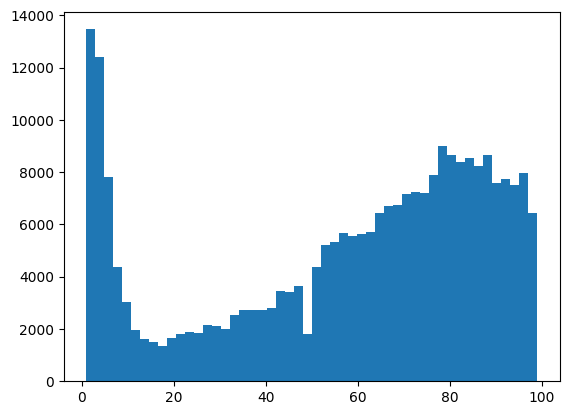

In [38]:
df["c_len"] = df["context"].map(lambda x: len(x.split(" ")))
npa = df[["c_len"]].to_numpy()
npa = npa[npa < 100]
plt.hist(npa, bins=50)

In [6]:
sum(df["c_len"] > 15) / len(df["c_len"]) # About 12 percent of the contexts are shorter than 15 words

0.880945402013075

Secondly, we want to know if this is evenly distributed through all datasets or if there is some bias

(array([ 2046.,  1467.,  5204., 11132.,  8171.,  7903.,  6742.,   184.,
          522.,  1301.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

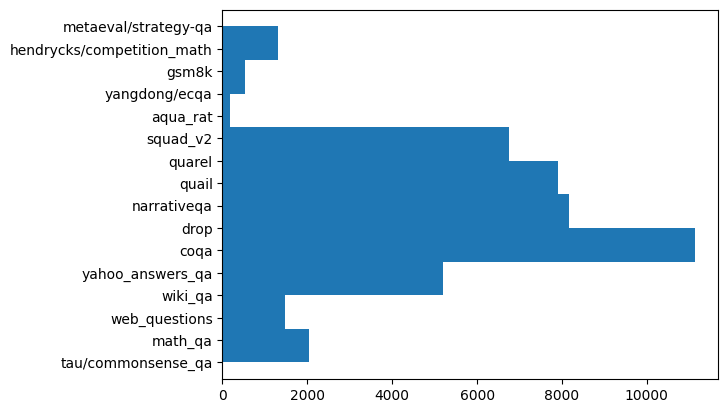

In [7]:
df["c_len"] = df["context"].map(lambda x: len(x.split(" ")))
df["src"] = df['src'].astype('category') 

filtered = df[df["c_len"] < 15]

plt.hist(filtered["src"], orientation="horizontal")

In [8]:
df["src"].value_counts()

src
squad_v2                      60000
narrativeqa                   30000
quail                         30000
coqa                          28796
yahoo_answers_qa              22500
wiki_qa                       22500
aqua_rat                      22500
math_qa                       22500
hendrycks/competition_math    22500
yangdong/ecqa                 22500
gsm8k                         22419
drop                          22256
tau/commonsense_qa            22104
web_questions                 11334
cnn_dailymail                  7500
metaeval/strategy-qa           6870
quarel                         5823
Name: count, dtype: int64

In [9]:
# Check for duplicates
len(df[df.duplicated()])

72

In [10]:
duplicates = df[df.duplicated(keep=False)]
duplicates

,Unnamed: 0,split,query,prediction,context,src,id,context_src,context_id,original_context,task,domain,c_len
220,NaN,llm,What are the names of Charlie Ergen's sons?,"Christoper Ergen, Chase Ergen","Charlie Ergen (born 1953), American businessma...",drop,95b3a343-edcd-4ca8-8e4f-346a00f37bf7,wiki,Ergen,False,qa,rc,35
221,NaN,llm,What are the names of Charlie Ergen's sons?,"Christoper Ergen, Chase Ergen","Charlie Ergen (born 1953), American businessma...",drop,95b3a343-edcd-4ca8-8e4f-346a00f37bf7,wiki,Ergen,False,qa,rc,35
277,NaN,llm,How many points were scored in the third quarter?,0,Scoring Summary: 1st Quarter: 2nd Quarter: 3rd...,drop,26661704-d2fe-4f89-b867-937805290e8e,wiki,2007 New York Dragons season,False,qa,rc,10
278,NaN,llm,How many points were scored in the third quarter?,0,Scoring Summary: 1st Quarter: 2nd Quarter: 3rd...,drop,26661704-d2fe-4f89-b867-937805290e8e,wiki,2007 New York Dragons season,False,qa,rc,10
261,NaN,llm,Which player had the longest run of the game?,Reggie Hodges,Highest runs,drop,05925095-23cc-4243-bf1d-02e896a1b16b,wiki,New Zealand cricket team in Sri Lanka in 2013–14,False,qa,rc,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,NaN,llm,Xanthia can read 100 pages per hour and Molly ...,Reading the book takes Xanthia\n\n$\frac{225}{...,"big. Now try something smaller, like choice (D...",hendrycks/competition_math,hendrycks/competition_math_5477,oscar,15073804,False,qa,cotr,51
202,NaN,llm,Does frost mean that it will be a snowy day?\n...,False,Frost forms on solid objects when the water va...,metaeval/strategy-qa,137d189866b9e69845c1,oscar,9951488,False,tf,cotr,100
203,NaN,llm,Does frost mean that it will be a snowy day?\n...,False,Frost forms on solid objects when the water va...,metaeval/strategy-qa,137d189866b9e69845c1,oscar,9951488,False,tf,cotr,100
133,NaN,llm,Is World of Warcraft heavier than a loaf of br...,False,Base WordPress Theme For Development Free Item...,metaeval/strategy-qa,06361fd92f628fe402e6,oscar,9635455,False,tf,cotr,60


In [11]:
d = df[df.duplicated()]
d["src"].value_counts()

src
squad_v2                      26
narrativeqa                   14
drop                           9
quail                          7
yangdong/ecqa                  7
gsm8k                          4
metaeval/strategy-qa           2
hendrycks/competition_math     1
quarel                         1
aqua_rat                       1
math_qa                        0
cnn_dailymail                  0
coqa                           0
tau/commonsense_qa             0
web_questions                  0
wiki_qa                        0
yahoo_answers_qa               0
Name: count, dtype: int64

(array([ 9., 14.,  7.,  1., 26.,  1.,  7.,  4.,  1.,  2.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

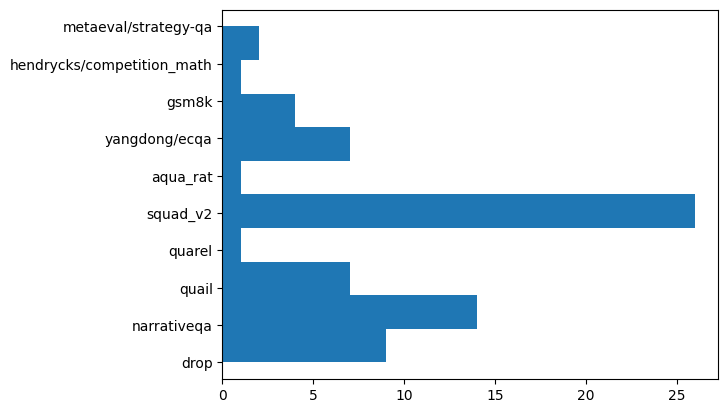

In [12]:
# Duplicates per dataset
plt.hist(d["src"], orientation="horizontal")

In [39]:
df_new = df.drop_duplicates()
df_new = df_new[df_new["c_len"] > 15]

In [40]:
final_examples = len(df_new)
print(final_examples, final_examples / len(df), len(df))

336587 0.8808825915593218 382102


In [41]:
df_new.to_parquet("../data/dataset/itrf_dataset_llm_processed2.parquet")

(array([ 2865.,  2654.,  2821.,  4156.,  3033.,  4035.,  5247.,  4214.,
         4995.,  7319.,  6763.,  8149., 11216.,  8409.,  9332., 13446.,
        10658., 10991., 16902., 12954., 12659., 16932., 11698., 11155.,
        14399.]),
 array([16.  , 19.32, 22.64, 25.96, 29.28, 32.6 , 35.92, 39.24, 42.56,
        45.88, 49.2 , 52.52, 55.84, 59.16, 62.48, 65.8 , 69.12, 72.44,
        75.76, 79.08, 82.4 , 85.72, 89.04, 92.36, 95.68, 99.  ]),
 <BarContainer object of 25 artists>)

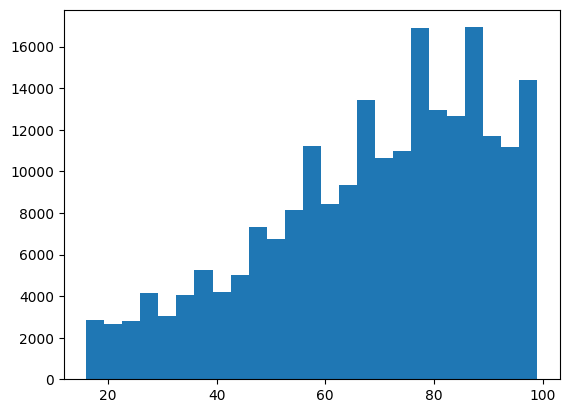

In [15]:
npy = df_new[["c_len"]].to_numpy()
npy = npy[npy < 100]
plt.hist(npy, bins=25)

(array([42505., 29591., 19933., 36372., 25108., 27719., 60717., 22304.,
        44356., 27982.]),
 array([ 0. ,  1.6,  3.2,  4.8,  6.4,  8. ,  9.6, 11.2, 12.8, 14.4, 16. ]),
 <BarContainer object of 10 artists>)

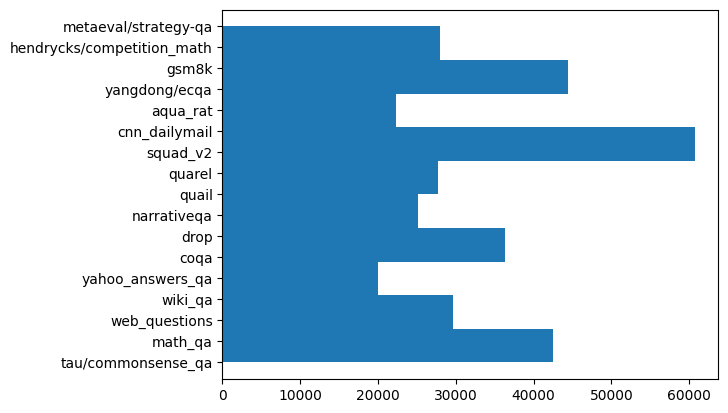

In [17]:
# Distribution of the datasets
plt.hist(df_new["src"], orientation="horizontal")

In [27]:
# Squad unanswered questions
squad = df_new[df_new["src"] == "squad_v2"]
len(squad[squad["prediction"] == "I don't know."])

17103

In [30]:
# Unanswerable questions
len(df_new[df_new["prediction"] == "I don't know."])

19654

In [33]:
df_new["domain"] = df_new['domain'].astype('category') 

(array([100938.,      0.,      0., 176875.,      0.,      0.,   7500.,
             0.,      0.,  96789.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

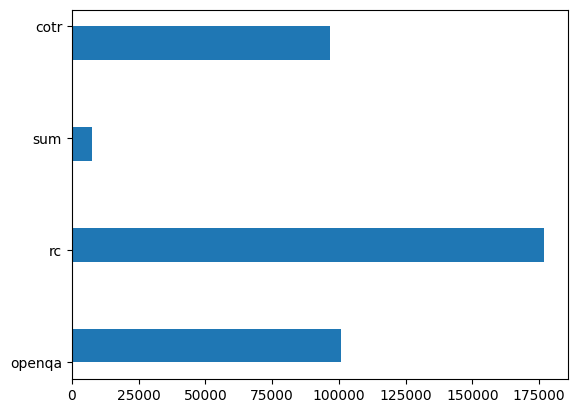

In [34]:
plt.hist(df["domain"], orientation="horizontal")

In [11]:
d = load_dataset("parquet", data_files=["../data/dataset/itrf_dataset_llm_processed2.parquet", "../data/dataset/itrf_dataset_llm.parquet"])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Failed to read file '/workspace/MasterThesis/create_dataset/../data/dataset/rarit_dataset_llm.parquet' with error <class 'ValueError'>: Couldn't cast
Unnamed: 0: double
split: string
query: string
prediction: string
context: string
src: string
id: string
context_src: string
context_id: string
original_context: bool
task: string
domain: string
__index_level_0__: int64
-- schema metadata --
pandas: '{"index_columns": ["__index_level_0__"], "column_indexes": [{"na' + 1703
to
{'Unnamed: 0': Value(dtype='float64', id=None), 'split': Value(dtype='string', id=None), 'query': Value(dtype='string', id=None), 'prediction': Value(dtype='string', id=None), 'context': Value(dtype='string', id=None), 'src': Value(dtype='string', id=None), 'id': Value(dtype='string', id=None), 'context_src': Value(dtype='string', id=None), 'context_id': Value(dtype='string', id=None), 'original_context': Value(dtype='bool', id=None), 'task': Value(dtype='string', id=None), 'domain': Value(dtype='string', id=None), 'c

DatasetGenerationError: An error occurred while generating the dataset

In [8]:
d.rename_column("prediction", "ground_truth")

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'split', 'query', 'ground_truth', 'context', 'src', 'id', 'context_src', 'context_id', 'original_context', 'task', 'domain', 'c_len', '__index_level_0__'],
        num_rows: 336587
    })
})

In [9]:
d.push_to_hub("tristanratz/itrf")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/337 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/745 [00:00<?, ?B/s]